In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt

In [2]:
encoding='utf-8'

twitter_contents = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/training.1600000.processed.noemoticon.csv", 
                               encoding='latin1', header=None, names = ['emotion', 'ids', 'date', 'flag', 'user', 'text'])

twitter_contents.isnull().values.any()

twitter_contents.shape

(1600000, 6)

In [3]:
twitter_contents.head()

,emotion,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
col_n = ['emotion', 'text']

twitter_contents = pd.DataFrame(twitter_contents,columns = col_n)

In [5]:
twitter_contents.head()

,emotion,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [6]:
twitter_contents["text"][7865]

'Seems like twitter is glitching again... Last two tweets have been stuck @ the top...  *crawls back under social networking rock*'

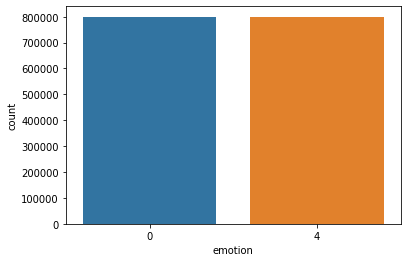

In [7]:
import seaborn as sns

sns.countplot(x='emotion', data=twitter_contents)

In [8]:
def preprocess_text(sen):
    # Removing html tags
    #sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    #sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # remove the content after the @
    sentence = re.sub(r'@.*$', ' ', sentence)

    return sentence

In [9]:
X = []
sentences = list(twitter_contents['text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [10]:
X[7865]

'Seems like twitter is glitching again Last two tweets have been stuck the top crawls back under social networking rock '

In [11]:
y = twitter_contents['emotion']
y = np.array(y)

#y = np.array(list(map(lambda x: 1 if x==4 else 0, y)))
y

array([0, 0, 0, ..., 4, 4, 4])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [13]:
X_train[7787]

'Anyone keen to follow MTV Movie Awards tweets check out marcmalkin from E '

In [ ]:
tokenizer = Tokenizer(num_words=250000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train[7787]

[386, 5109, 2, 244, 811, 228, 729, 422, 325, 36, 84445, 58, 390]

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 50

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
X_train[7787]

array([  386,  5109,     2,   244,   811,   228,   729,   422,   325,
          36, 84445,    58,   390,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [ ]:
vocab_size

507856

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/Colab Notebooks/glove.twitter.27B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(507856, 50)

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.043148  ,  0.50392997,  0.27094999, ..., -0.22383   ,
        -0.66025001, -0.70648998],
       [ 0.54964   ,  0.032752  ,  0.19354001, ...,  0.21378   ,
         0.23067001,  0.20011   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.34762999, -0.097932  , -0.46309   , ..., -0.35912001,
        -0.22274999, -0.15973   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
#model.add(Dense(1500, activation='sigmoid'))
model.add(Dense(80, activation='relu'))

model.add(Dense(50, activation='sigmoid'))

model.add(Dense(30, activation='sigmoid'))

#model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            25392800  
_________________________________________________________________
flatten (Flatten)            (None, 2500)              0         
_________________________________________________________________
dense (Dense)                (None, 80)                200080    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 25,598,491
Trainable params: 205,691
Non-trainable params: 25,392,800
______________________________________

In [ ]:
history = model.fit(X_train, y_train, batch_size=256, epochs=25, verbose=1, validation_split=0.1)

Epoch 1/25
4500/4500 [==============================] - 13s 3ms/step - loss: -57.5689 - acc: 0.0469 - val_loss: -111.9566 - val_acc: 0.0761
Epoch 2/25
4500/4500 [==============================] - 13s 3ms/step - loss: -166.1227 - acc: 0.0989 - val_loss: -218.5551 - val_acc: 0.1363
Epoch 3/25
4500/4500 [==============================] - 13s 3ms/step - loss: -275.2612 - acc: 0.1197 - val_loss: -328.5024 - val_acc: 0.1409
Epoch 4/25
4500/4500 [==============================] - 13s 3ms/step - loss: -385.4397 - acc: 0.1356 - val_loss: -435.8351 - val_acc: 0.0000e+00
Epoch 5/25
4500/4500 [==============================] - 13s 3ms/step - loss: -495.8461 - acc: 0.1449 - val_loss: -545.2866 - val_acc: 0.1074
Epoch 6/25
4500/4500 [==============================] - 13s 3ms/step - loss: -607.3102 - acc: 0.1531 - val_loss: -651.2093 - val_acc: 0.0000e+00
Epoch 7/25
4500/4500 [==============================] - 13s 3ms/step - loss: -719.2808 - acc: 0.1544 - val_loss: -758.6937 - val_acc: 0.2043
Epoch 

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

10000/10000 [==============================] - 21s 2ms/step - loss: -2747.4917 - acc: 0.2016


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: -2747.49169921875
Test Accuracy: 0.20159687101840973


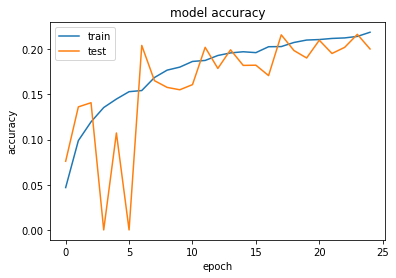

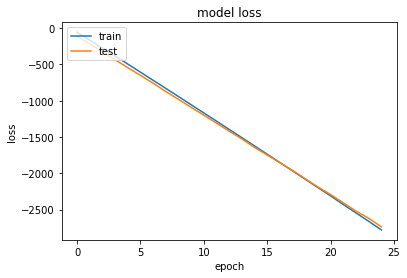

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [ ]:
instance = X[113896]
print(instance)

omg sinus infection so that was you lurking behind yesterday s headache just don t stay too long okay 


In [ ]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

a = model.predict(instance)
print(float(a))

1.0


In [ ]:
from keras.layers import SimpleRNN

model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
#model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=False) )
# 64 64---50%
#model.add(SimpleRNN(5))
model.add(Dense(16, activation='sigmoid'))
#model.add(Dense(16, activation='sigmoid'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            25392800  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2656      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 25,396,001
Trainable params: 3,201
Non-trainable params: 25,392,800
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=2048, epochs=4, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/4
500/500 [==============================] - 14s 27ms/step - loss: -3.7474 - acc: 0.0085 - val_loss: -6.4362 - val_acc: 5.8594e-04
Epoch 2/4
500/500 [==============================] - 13s 27ms/step - loss: -9.1060 - acc: 8.2520e-04 - val_loss: -11.7123 - val_acc: 8.9453e-04
Epoch 3/4
500/500 [==============================] - 13s 27ms/step - loss: -14.2099 - acc: 4.4727e-04 - val_loss: -16.7549 - val_acc: 0.0000e+00
Epoch 4/4
10000/10000 [==============================] - 51s 5ms/step - loss: -24.2740 - acc: 0.0000e+00


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: -24.274017333984375
Test Accuracy: 0.0


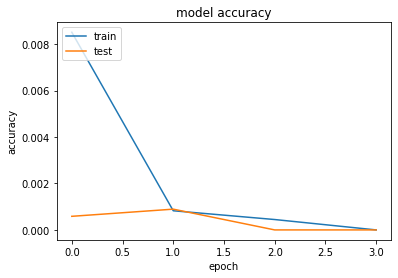

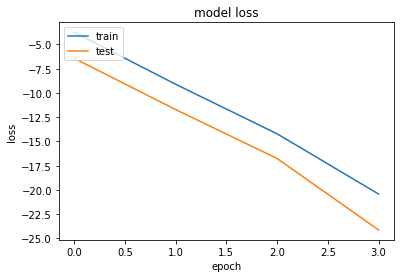

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
instance = X[1584247]
print(instance)

Low on energy calling it a night Sweet dreams Twitters 


In [ ]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

a = model.predict(instance)
print(float(a))

1.0
